In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

In [3]:
os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

### Examine the combined enrichment distributions

In [4]:
df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False)

In [5]:
df_all.describe()

,high,med,low-t
count,829144.000000,829144.000000,829144.000000
mean,5.738704,3.741781,8.380919
std,31.848957,9.404503,9.271202
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,6.000000
75%,0.000000,1.000000,13.000000
max,1185.000000,232.000000,453.000000


In [6]:
cols = ['royalblue', 'gold', 'salmon']

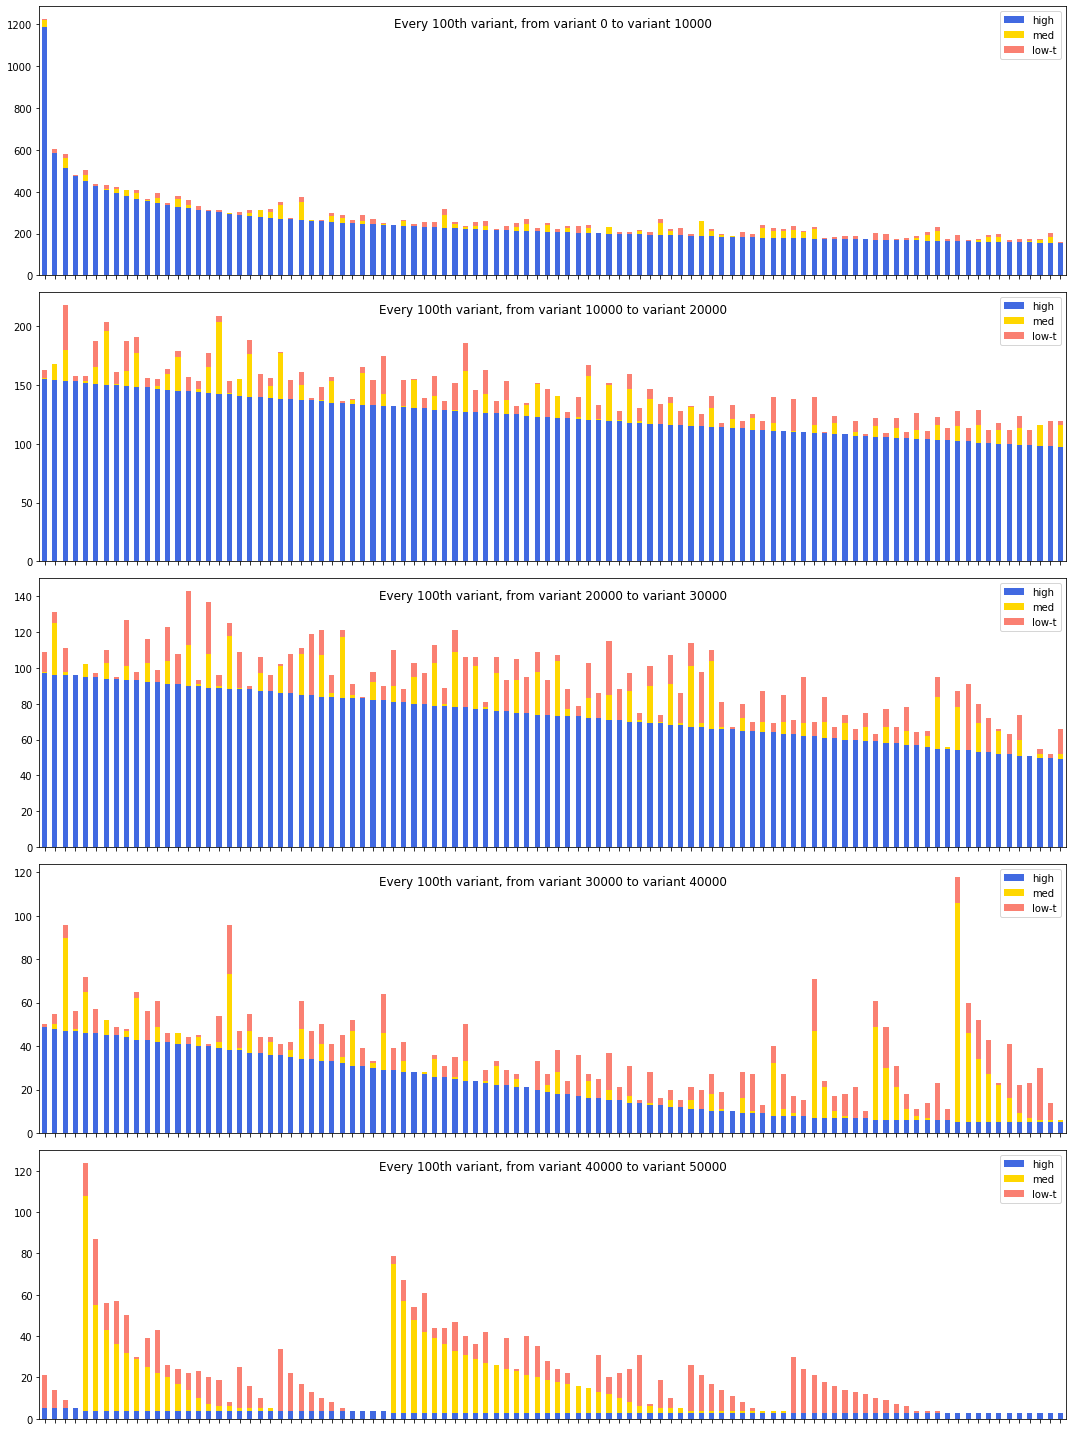

In [7]:
split = 10000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[p*split:(p+1)*split:100].plot.bar(stacked=True, ax=axes[p], color = cols)
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 100th variant, from variant ' + str(p*split) + ' to variant ' + str((p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()
plt.savefig('Read_distribution.png', dpi=300)

plt.show()

The probability that a variant is truly 'active' decreases going down the plots, with a clear trend:
- the top 10K variants are 'active' with a high confidence, the appearance of variants in the medium and low gates is just experimental noise
- with some more variability, the same can be said for the next 10-20Ks variants, shown on the second plot. This covers variants with 100+ High reads
- looking at the last two plots, there is a high degree of variability in read distribution once we reach <20 reads in high gate. There, further investigation is needed. Two avenues: check the variants from 20K onwards at higher resolution to pin down the cutoff high gate count, and b) take the variants with fewer high counts below that and re-sort according to medium gate distribution. Especially in the less active variants that become the dominant factor.

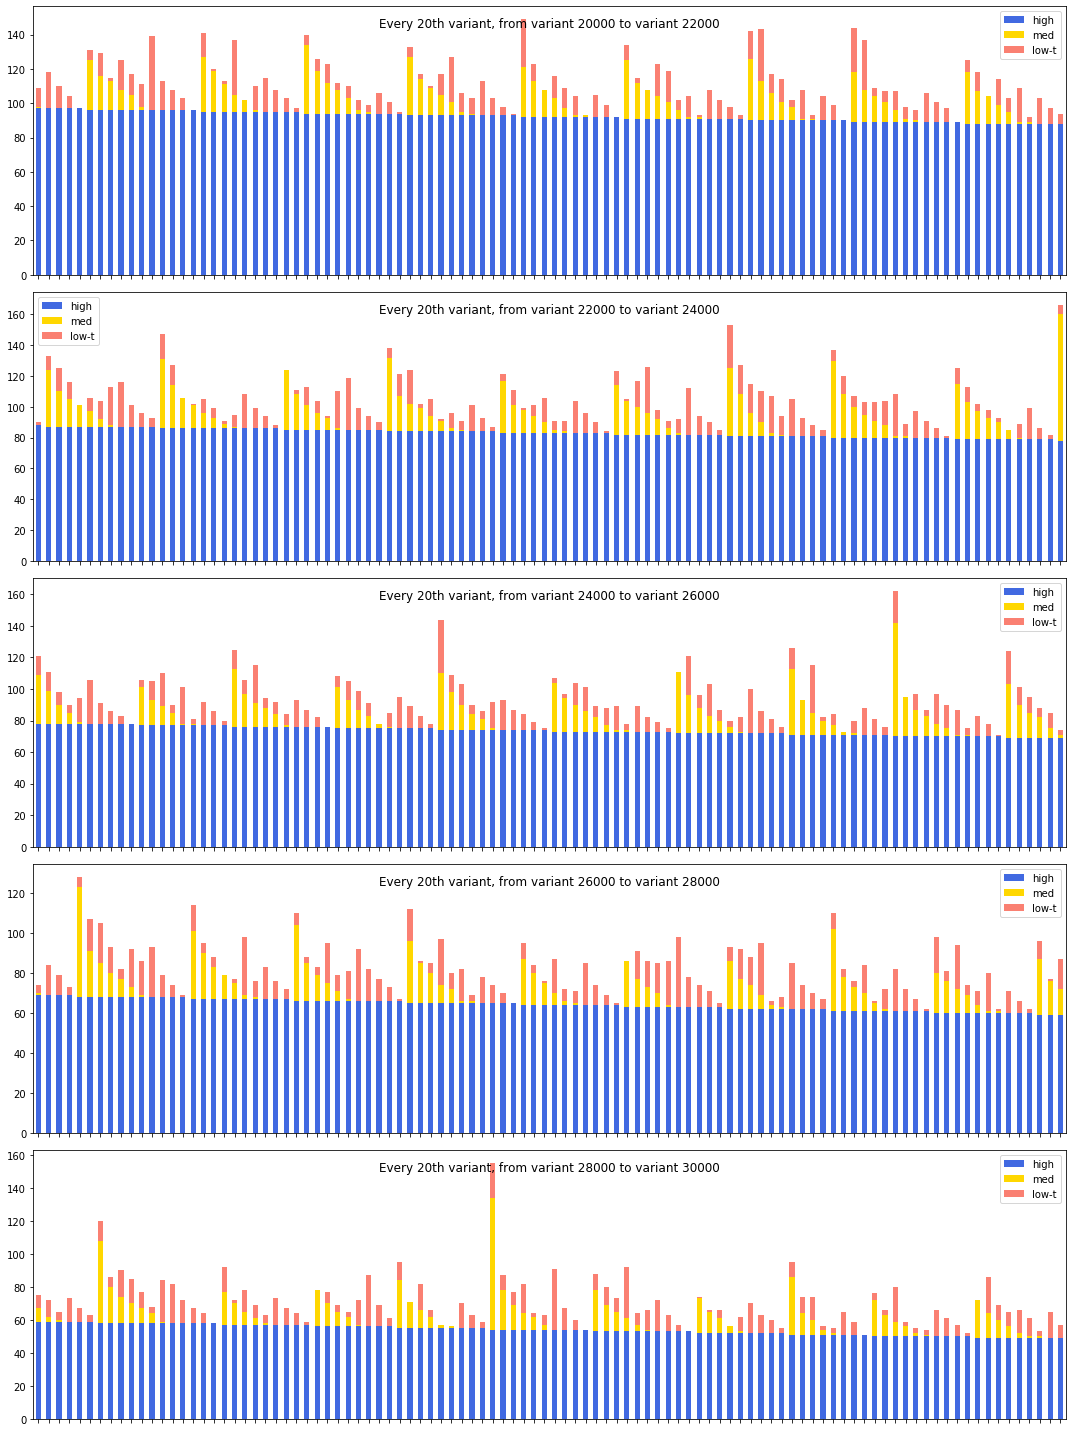

In [8]:
os = 20000
split = 2000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[os+p*split:os+(p+1)*split:20].plot.bar(stacked=True, ax=axes[p], color = cols)
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 20th variant, from variant ' + str(os+p*split) + ' to variant ' + str(os+(p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

These plots show that from variant 20K to variant 30K there is increasing variation in the frequencies in medium and low gates. On the whole, the precise activity level for some of the variants is less clear-cut because some are equally or more frequent in the medium gate - are they 'active' and depleted from the sort? Or are they truly less active variants?

So, variants with 50+ reads in high gate are 'active'. Let's add some mild filtering to these variants, requiring that the low reads can be <20% of the combined medium + high reads.

In [9]:
df_50p = df_all.loc[(df_all['high'] >= 50) & ((df_all['high']+df_all['med']) > 2*df_all['low-t'])]
df_50p.describe()

,high,med,low-t
count,29725.000000,29725.000000,29725.000000
mean,145.750076,11.551724,11.230446
std,87.760870,15.494472,8.197057
min,50.000000,0.000000,0.000000
25%,86.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,162.000000,69.000000


Then, let's try to stratify the distribution in variants below 50 reads in high gate.

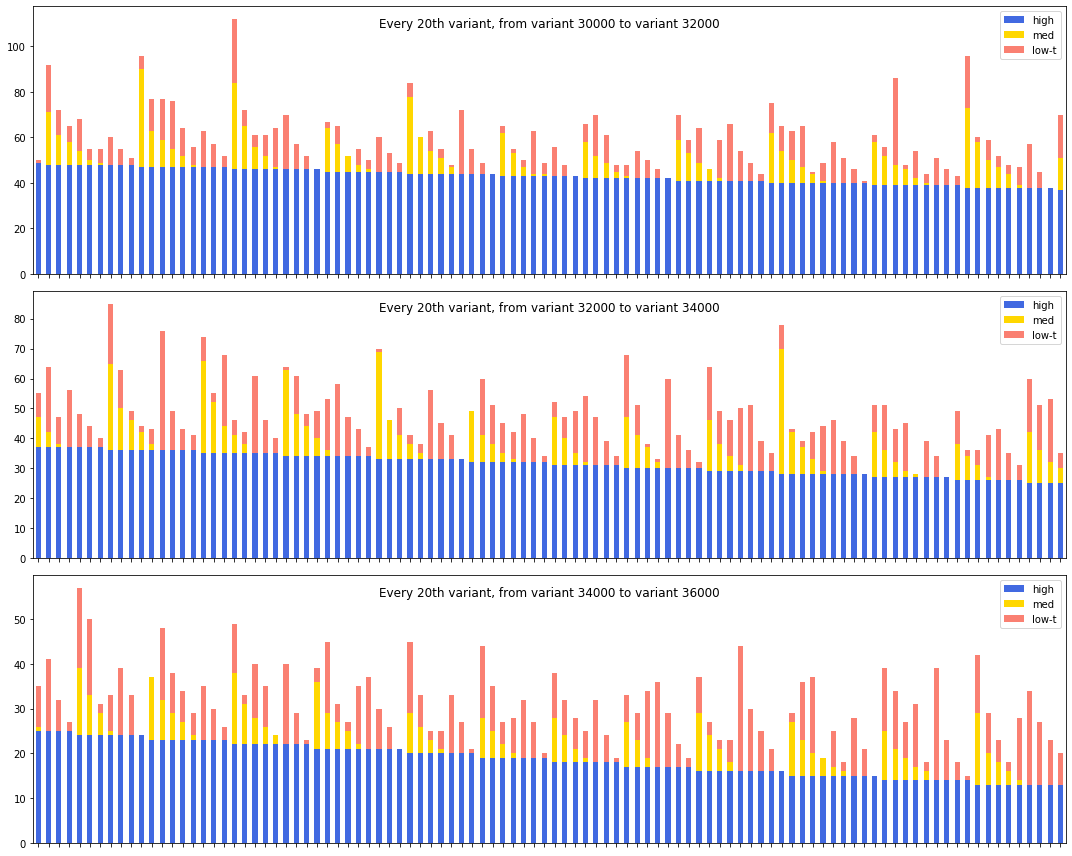

In [10]:
os = 30000
split = 2000
n=3

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[os+p*split:os+(p+1)*split:20].plot.bar(stacked=True, ax=axes[p], color = cols)
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 20th variant, from variant ' + str(os+p*split) + ' to variant ' + str(os+(p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

Below 30 reads in high gate, things are starting to look iffy. Still, there is a proportion of variants with reads only (or nearly only) in high gate.
- if the high gate is >10, accept as long as <20% of high+medium gate reads appear in the low gate, and # high gate > # medium gate.Remkes, how many reads in medium gate are okay?

So let's pick out those variants.

In [11]:
df_20to50 = df_all.loc[(df_all['high'].isin(range(10,50))) & 
                       (df_all['high'] > df_all['med']) & 
                       ((df_all['high']+df_all['med']) > 5*df_all['low-t']) ]

In [12]:
df_20to50.describe()

,high,med,low-t
count,2652.000000,2652.000000,2652.000000
mean,34.606335,6.297511,3.915158
std,10.655488,7.862844,2.905653
min,10.000000,0.000000,0.000000
25%,27.000000,0.000000,2.000000
50%,37.000000,3.000000,4.000000
75%,43.000000,10.000000,6.000000
max,49.000000,48.000000,18.000000


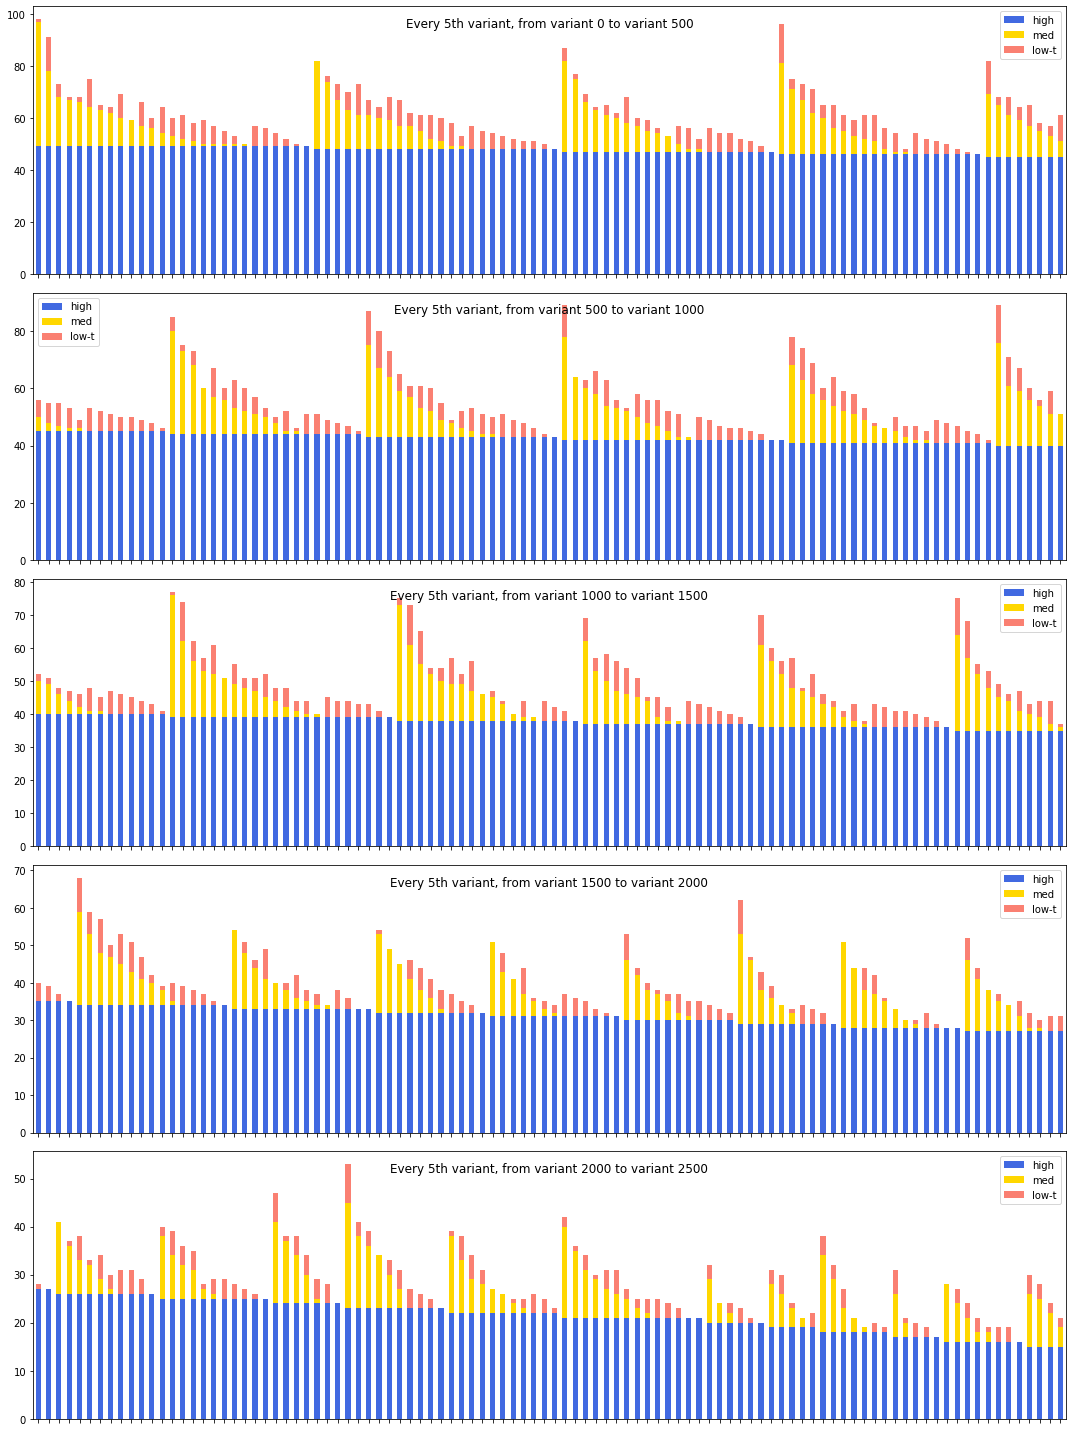

In [13]:
os = 0
split = 500
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_20to50.iloc[os+p*split:os+(p+1)*split:5].plot.bar(stacked=True, ax=axes[p], color = cols)
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 5th variant, from variant ' + str(os+p*split) + ' to variant ' + str(os+(p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

In [14]:
df_pos = df_50p.append(df_20to50)
pos = df_pos.to_dict()
df_pos.describe()

,high,med,low-t
count,32377.000000,32377.000000,32377.000000
mean,136.646292,11.121352,10.631251
std,89.495014,15.084813,8.148840
min,10.000000,0.000000,0.000000
25%,77.000000,0.000000,5.000000
50%,116.000000,3.000000,9.000000
75%,171.000000,18.000000,15.000000
max,1185.000000,162.000000,69.000000


In [15]:
df_pos.head()

,high,med,low-t
6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0
6F/7aP/9W/11L/13M,903.0,81.0,15.0
6L/7aF/9L/11I/13I,899.0,2.0,8.0
6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0
6W/7aI/9F/11L/13V,880.0,34.0,20.0


#### Check if the final dataset contains any variants with mutations outside the designed positions

In [16]:
from ipynb.fs.defs.Library_diversity import convert_variant_to_dict

def n_altered_positions(short):
    return len(convert_variant_to_dict(short))

In [17]:
df_pos['short'] = df_pos.index 
df_pos['nMuts'] = df_pos['short'].apply(n_altered_positions)

In [18]:
df_pos[df_pos['nMuts'] > 6]

,high,med,low-t,short,nMuts
6L/7aL/9A/9a*,53.0,33.0,42.0,6L/7aL/9A/9a*,7
6L/7aI/9A/9a*,53.0,24.0,23.0,6L/7aI/9A/9a*,7


There are two such variants out of 32400, so we drop those.

In [19]:
df_pos = df_pos.drop(['6L/7aL/9A/9a*', '6L/7aI/9A/9a*'])

Here, the filtering steps have been completed: the result is a dataset with 32,4K variants that we are confident to call active MEK1 variants. Next, I use these variants to explore the enrichment of different amino acids amongst positive variants.

### Identify the single mutants in this dataset

In [20]:
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
pos_aa = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

In [21]:
from ipynb.fs.defs.SSNs import hamming_distance

In [22]:
wt_short = '6P/9I/11L/13P'
wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

In [23]:
positive_vars = df_pos.index.tolist()

In [24]:
n_single = 0
single_pos_muts = []
for short in positive_vars:
    s = convert_variant_to_dict(short)
    h_dis = hamming_distance(s, wt, wt)
    if h_dis in [0,1]:
        n_single += 1
        single_pos_muts.append(short)
print(n_single)

14


6: P,I = 2

7a: Δ,L,K = 3

9: I,P,F = 3

11: F,L,M,I = 4

13: P,I,L,W,V,F = 6


So the max number of additive variants would be 432 variants



In [25]:
2*3*3*4*6

432

### Check what reads distribution is in the other point mutants

In total, 57 point mutants relative to MKK1 wt sequence are possible. Of those, we observe 13 in the curated dataset.

In [26]:
11+12+1+11+11+11

57

In [27]:
single_pos_muts

['6P/9I/11F/13P',
 '6P/9I/11L/13I',
 '6P/9I/11L/13L',
 '6P/7aL/9I/11L/13P',
 '6P/9P/11L/13P',
 '6P/9F/11L/13P',
 '6P/7aK/9I/11L/13P',
 '6P/9I/11L/13W',
 '6P/9I/11M/13P',
 '6I/9I/11L/13P',
 '6P/9I/11L/13V',
 '6P/9I/11I/13P',
 '6P/9I/11L/13F',
 '6P/9I/11L/13P']

In [28]:
def format_point_mutant(short):
    position_order = ['6', '7a', '8a', '9', '11', '13']
    
    m_by_pos = convert_variant_to_dict(short)
    aa_sequence_shorthand = []
    for p in position_order:
        if m_by_pos[p] == 'Δ':
            aa_sequence_shorthand.append('-')
        else:
            aa_sequence_shorthand.append(m_by_pos[p])
    return ''.join(aa_sequence_shorthand)

In [29]:
def add_nice_labels(df):
    df['short'] = df.index 
    df['fig_format'] = df['short'].apply(format_point_mutant)
    return df

In [30]:
point_high_df = add_nice_labels(df_pos[df_pos.index.isin(single_pos_muts)])

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


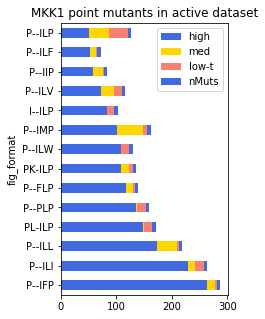

In [31]:
fig, ax = plt.subplots(1, 1,figsize=(3,5))
point_high_df.plot.barh(stacked=True, ax=ax, color=cols, 
                        x='fig_format' ,title='MKK1 point mutants in active dataset')
#plt.savefig('Point_mutants_active_h.svg', transparent=True)
plt.show()

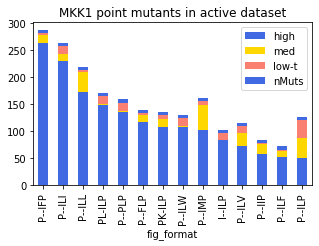

In [32]:
fig, ax = plt.subplots(1, 1,figsize=(5,3))
point_high_df.plot.bar(stacked=True, ax=ax, color=cols, 
                       x='fig_format', title='MKK1 point mutants in active dataset')
#plt.savefig('Point_mutants_active.svg', transparent=True)
plt.show()

In [33]:
def variant_is_allowed(m_by_pos, pos_aa):
    if len(m_by_pos) != len(pos_aa):
        return False
    for p, aa in m_by_pos.items():
        if aa not in pos_aa[p]:
            return False
    return True

In [34]:
all_vars = df_all.index.tolist()

n_neg_single = 0
single_neg_muts = []
for short in all_vars:
    s = convert_variant_to_dict(short)
    # check that it's not a sequencing error
    if not variant_is_allowed(s, pos_aa):
        continue
    
    h_dis = hamming_distance(s, wt, wt)  
    if h_dis == 1:
        if short not in single_pos_muts:
            n_neg_single += 1
            single_neg_muts.append(short)
            
print(n_neg_single)

43


In [35]:
print(single_neg_muts)

['6P/9I/11W/13P', '6P/9L/11L/13P', '6P/9M/11L/13P', '6P/9I/11L/13A', '6L/9I/11L/13P', '6P/9I/11L/13M', '6P/7aM/9I/11L/13P', '6P/9I/11L/13G', '6F/9I/11L/13P', '6V/9I/11L/13P', '6P/9I/11V/13P', '6P/9Y/11L/13P', '6P/7aI/9I/11L/13P', '6K/9I/11L/13P', '6P/7aA/9I/11L/13P', '6A/9I/11L/13P', '6P/9V/11L/13P', '6P/7aV/9I/11L/13P', '6Y/9I/11L/13P', '6P/9A/11L/13P', '6D/9I/11L/13P', '6P/9I/11P/13P', '6P/9I/11Y/13P', '6P/7aW/9I/11L/13P', '6P/9I/11K/13P', '6G/9I/11L/13P', '6P/9I/11L/13K', '6P/8aA/9I/11L/13P', '6W/9I/11L/13P', '6P/9I/11L/13D', '6M/9I/11L/13P', '6P/7aP/9I/11L/13P', '6P/9I/11L/13Y', '6P/9D/11L/13P', '6P/7aG/9I/11L/13P', '6P/9I/11A/13P', '6P/9I/11D/13P', '6P/7aD/9I/11L/13P', '6P/9G/11L/13P', '6P/9K/11L/13P', '6P/7aF/9I/11L/13P', '6P/9I/11G/13P', '6P/9W/11L/13P']


In [36]:
point_low_df = add_nice_labels(df_all[df_all.index.isin(single_neg_muts)])

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


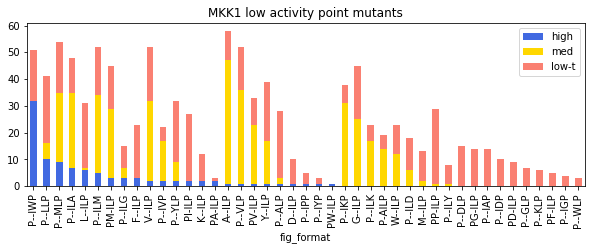

In [37]:
fig, ax = plt.subplots(1, 1,figsize=(10,3))
point_low_df.plot.bar(stacked=True, ax=ax, color= cols, 
                      x='fig_format', title='MKK1 low activity point mutants')

# plt.xticks(rotation=45)
#plt.savefig('Point_mutants_inactive.svg', transparent=True)
plt.show()

In [38]:
57-13-43

1

That leaves only a single point mutant unaccounted for.

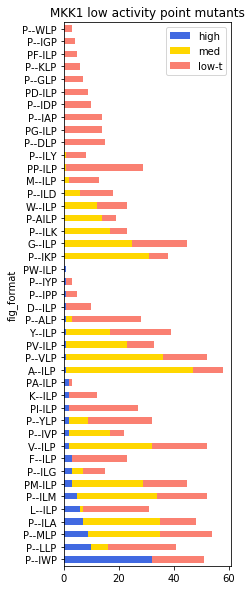

In [39]:
fig, ax = plt.subplots(1, 1,figsize=(3,10))
point_low_df.plot.barh(stacked=True, ax=ax, color=cols,
                       x='fig_format', title='MKK1 low activity point mutants')
#plt.savefig('Point_mutants_inactive.svg', transparent=True)
plt.show()